# サーバの状態の調査

M先輩から「wikiのサーバ、中で何動いてるかレポート作って」と指示があった

作業開始時刻

In [21]:
!date

Thu Jul 26 11:04:02 UTC 2018


# 対象の確認

ansibleのインベントリファイルで対象サーバを確認し、簡単なコマンドが通ることを確認しておく

In [22]:
hosts = !cat ./hosts
hosts

['openforum2018_wiki_1', 'openforum2018_3dwebmap_1', 'openforum2018_boinc_1']

In [23]:
for h in hosts:
        if h.find('wiki') > -1:
            target = ' -i ./hosts {} -c docker'.format(h)
target

' -i ./hosts openforum2018_wiki_1 -c docker'

In [24]:
!sudo ansible -a "ls -la" {target}

openforum2018_wiki_1 | SUCCESS | rc=0 >>
total 152
drwxr-xr-x 1 wiki wiki  4096 Nov  5  2017 .
drwxr-xr-x 1 wiki wiki  4096 Jul 26 09:55 ..
-rw-r--r-- 1 wiki wiki    40 Sep  8  2014 .bowerrc
drwxr-xr-x 1 wiki wiki  4096 Nov  5  2017 .git
-rwxr-xr-x 1 wiki wiki   228 Nov  4  2017 .gitignore
drwxr-xr-x 1 wiki wiki  4096 Nov  5  2017 .idea
-rw-r--r-- 1 wiki wiki   305 Nov  4  2017 .travis.yml
drwxr-xr-x 1 wiki wiki  4096 Nov  5  2017 .vagrant
drwxr-xr-x 1 wiki wiki  4096 Nov  5  2017 .venv
-rw-r--r-- 1 wiki wiki 18041 Sep  8  2014 LICENSE
-rw-r--r-- 1 wiki wiki   151 Aug 20  2017 MANIFEST.in
-rw-r--r-- 1 wiki wiki   616 Nov  4  2017 Pipfile
-rw-r--r-- 1 wiki wiki  4784 Nov  4  2017 Pipfile.lock
-rw-r--r-- 1 wiki wiki 17027 Nov  5  2017 README.md
-rw-r--r-- 1 wiki wiki   321 Nov  5  2017 Vagrantfile
-rw-r--r-- 1 wiki wiki   531 Nov  4  2017 bower.json
drwxr-xr-x 4 wiki wiki  4096 Nov  5  2017 build
drwxr-xr-x 1 wiki wiki  4096 Nov  5  2017 dist
drwxr-xr-x 1 wiki wiki  4096 Nov  5  2017 doc

# サーバの基本情報を収集

## OSのバージョン

In [25]:
command = "'cat /etc/issue'"
!sudo ansible -a {command} {target}

openforum2018_wiki_1 | SUCCESS | rc=0 >>
Ubuntu 16.04.3 LTS \n \l



https://ja.wikipedia.org/wiki/Ubuntu#%E3%83%AA%E3%83%AA%E3%83%BC%E3%82%B9%E4%B8%80%E8%A6%A7

Ubuntu 16.04 LTS Xenial Xerus

## サービス

https://qiita.com/pocket8137/items/9df9ef5ad93e7b220c42

insserv -s でいけそう

In [8]:
command = "'insserv -s'"
!sudo ansible -a {command} {target}

openforum2018_wiki_1 | FAILED | rc=2 >>
[Errno 2] No such file or directory



RuntimeError: Unexpected exit code: 2

insserv は使えないのか

https://server-setting.info/debian/debian-like-chkconfig.html

同じ感じのコマンドで入ってる奴を探る感じで

In [9]:
command = "'sysv-rc-conf --list'"
!sudo ansible -a {command} {target}

openforum2018_wiki_1 | FAILED | rc=2 >>
[Errno 2] No such file or directory



RuntimeError: Unexpected exit code: 2

In [10]:
command = "'rcconf --list'"
!sudo ansible -a {command} {target}

openforum2018_wiki_1 | FAILED | rc=2 >>
[Errno 2] No such file or directory



RuntimeError: Unexpected exit code: 2

しょうがない。/etc/rc?.d の下を眺めてみよう

In [26]:
command = "'ls /etc/rc1.d/'"
!sudo ansible -a {command} {target}
command = "'ls /etc/rc2.d/'"
!sudo ansible -a {command} {target}
command = "'ls /etc/rc3.d/'"
!sudo ansible -a {command} {target}
command = "'ls /etc/rc4.d/'"
!sudo ansible -a {command} {target}
command = "'ls /etc/rc5.d/'"
!sudo ansible -a {command} {target}

openforum2018_wiki_1 | SUCCESS | rc=0 >>
README
S01killprocs
S02single

openforum2018_wiki_1 | SUCCESS | rc=0 >>
README
S01rsync
S02ondemand
S02rc.local

openforum2018_wiki_1 | SUCCESS | rc=0 >>
README
S01rsync
S02ondemand
S02rc.local

openforum2018_wiki_1 | SUCCESS | rc=0 >>
README
S01rsync
S02ondemand
S02rc.local

openforum2018_wiki_1 | SUCCESS | rc=0 >>
README
S01rsync
S02ondemand
S02rc.local



それっぽいサービスはない感じ

## プロセス

In [27]:
command = "'ps aux'"
!sudo ansible -a {command} {target}

openforum2018_wiki_1 | SUCCESS | rc=0 >>
USER        PID %CPU %MEM    VSZ   RSS TTY      STAT START   TIME COMMAND
wiki          1  0.0  0.0   4508     0 ?        Ss   09:54   0:00 /bin/sh -c . /home/wiki/realms-wiki/.venv/bin/activate &&     gunicorn         --name realms-wiki         --access-logfile -         --error-logfile -         --worker-class gevent         --workers ${WORKERS}         --bind 0.0.0.0:5000         --chdir /home/wiki/realms-wiki         'realms:create_app()'
wiki          5  0.0  0.3  53412  6608 ?        S    09:54   0:00 /home/wiki/realms-wiki/.venv/bin/python /home/wiki/realms-wiki/.venv/bin/gunicorn --name realms-wiki --access-logfile - --error-logfile - --worker-class gevent --workers 3 --bind 0.0.0.0:5000 --chdir /home/wiki/realms-wiki realms:create_app()
wiki         10  0.0  2.5 136172 52476 ?        S    09:54   0:02 /home/wiki/realms-wiki/.venv/bin/python /home/wiki/realms-wiki/.venv/bin/gunicorn --name realms-wiki --access-logfile - --error-logfile -

/home/wiki/realms-wiki 以下にある実行ファイルが、pythonで動いてる雰囲気

## LISTENポート

In [28]:
command = "'ss -lnat'"
!sudo ansible -a {command} {target}

openforum2018_wiki_1 | SUCCESS | rc=0 >>
State      Recv-Q Send-Q Local Address:Port               Peer Address:Port              
LISTEN     0      128          *:5000                     *:*                  



In [29]:
command = "'ss -lnau'"
!sudo ansible -a {command} {target}

openforum2018_wiki_1 | SUCCESS | rc=0 >>
State      Recv-Q Send-Q Local Address:Port               Peer Address:Port              



5000番ポートがLISTENしてる

# サービスの確認

5000番ポートにブラウザでアクセスしてみる

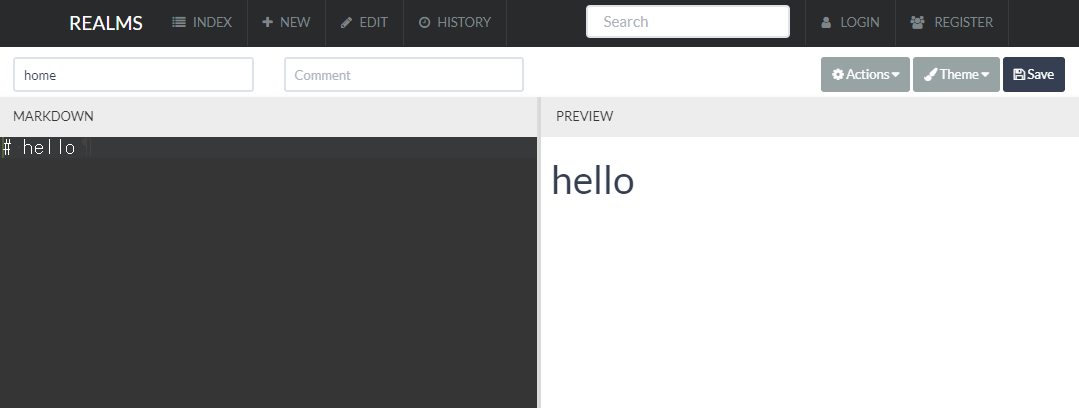

https://github.com/scragg0x/realms-wiki

wikiのようだ

# コンテナの確認

コンテナイメージを調べてなかった

In [30]:
!sudo docker ps -a

CONTAINER ID        IMAGE                         COMMAND                  CREATED             STATUS              PORTS                    NAMES
8bfeb173c599        realms/realms-wiki            "/bin/sh -c '. /home…"   About an hour ago   Up About an hour    0.0.0.0:5000->5000/tcp   openforum2018_wiki_1
b21c4f06092c        mnagaku/lc-minimal-notebook   "tini -g -- bash -c …"   About an hour ago   Up About an hour    0.0.0.0:8888->8888/tcp   openforum2018_jupyter_1
ee821e21ef04        tumgis/3dcitydb-web-map       "node server.js --pu…"   About an hour ago   Up About an hour    0.0.0.0:8000->8000/tcp   openforum2018_3dwebmap_1
692abba3e541        kyontan/boinc-runner          "/startup.sh"            About an hour ago   Up About an hour                             openforum2018_boinc_1


realms/realms-wiki を、docker hub で確認してみる

https://hub.docker.com/r/realms/realms-wiki/

これのようだ

https://github.com/scragg0x/realms-wiki#realms-wiki-via-docker

に指定されてるコンテナ名と一致するので、公式イメージっぽい

# まとめ

5000番ポートからサービスされてるpython製のwiki「realms」が動いている